In [22]:
import tensorflow as tf
import numpy as np
import sys

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# PCA with a linear Autoencoder

In [4]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [5]:
data.shape

(200, 3)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [7]:
reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [8]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    coding_vals = codings.eval(feed_dict={X: X_test})

In [9]:
coding_vals.shape

(100, 2)

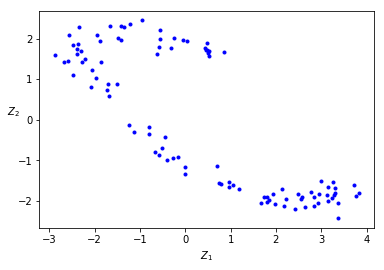

In [10]:
import matplotlib.pyplot as plt

plt.plot(coding_vals[:, 0], coding_vals[:, 1], "b.")
plt.xlabel(r"$Z_1$")
plt.ylabel(r"$Z_2$", rotation=0)
plt.show()

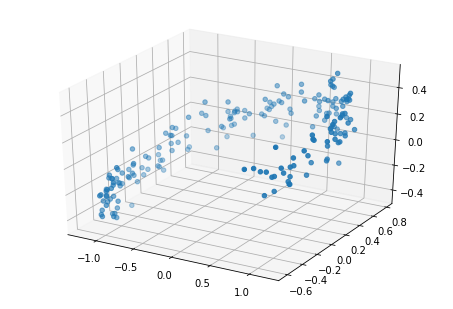

In [11]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure()
axes3d = Axes3D(fig)

axes3d.scatter(data[:, 0], data[:, 1], data[:, 2])
plt.show()

# Stacked Autoencoders

In [12]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [17]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1330d4cf8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1330d4828>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x137709da0>)

In [60]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense, 
                        activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [61]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()   
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r", epoch, "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt") 

 0 Train MSE: 0.026066799
 1 Train MSE: 0.014623563
 2 Train MSE: 0.011000128
 3 Train MSE: 0.010691896
 4 Train MSE: 0.010132245


In [43]:
def show_reconstruction_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
    
    print("outputs_val.shape=", outputs_val.shape)
    
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
    plt.show()

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
outputs_val.shape= (2, 784)


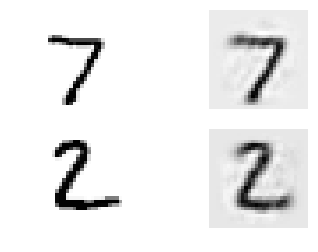

In [62]:
show_reconstruction_digits(X, outputs, "./my_model_all_layers.ckpt")

## Tying Weights

In [53]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [63]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [64]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()   
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r", epoch, "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt") 

 0 Train MSE: 0.014065557
 1 Train MSE: 0.008129357
 2 Train MSE: 0.0074769375
 3 Train MSE: 0.0074290815
 4 Train MSE: 0.0072105783


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt
outputs_val.shape= (2, 784)


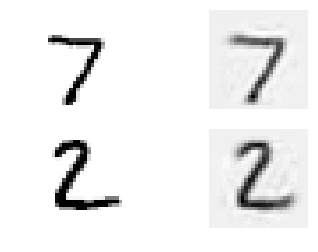

In [65]:
show_reconstruction_digits(X, outputs, "./my_model_tying_weights.ckpt")

## Training One Autoencoder at a Time

In [74]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_loss = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batchz_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

## Denoising Autocoders

In [91]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [92]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.elu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [93]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [94]:
n_epoch = 10
batch_size = 150

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epoch):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.04581761
1 Train MSE: 0.039681006
2 Train MSE: 0.03822099
3 Train MSE: 0.037250612
4 Train MSE: 0.03504262
59% Train MSE: 0.03419592
6 Train MSE: 0.033995003
7 Train MSE: 0.03498402
8 Train MSE: 0.036117658
9 Train MSE: 0.064504996


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt
outputs_val.shape= (2, 784)


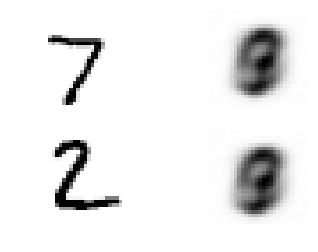

In [95]:
show_reconstruction_digits(X, outputs, "./my_model_stacked_denoising_gaussian.ckpt")

### Using Dropout

In [89]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

training = tf.placeholder_with_default(False, shape=(), name="training")

dropout_rate= 0.3
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.elu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epoch = 10
batch_size = 150

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epoch):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.03736624
1 Train MSE: 0.027160108
29% Train MSE: 0.021433635
3 Train MSE: 0.017701685
4 Train MSE: 0.015832167
5 Train MSE: 0.014314064
6 Train MSE: 0.012459818
79% Train MSE: 0.011110076
8 Train MSE: 0.011038063
9 Train MSE: 0.009869685


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt
outputs_val.shape= (2, 784)


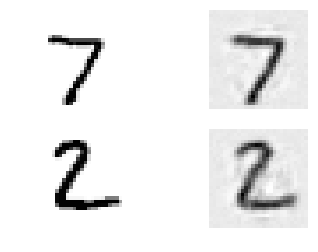

In [90]:
show_reconstruction_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## Sparse Autoencoder

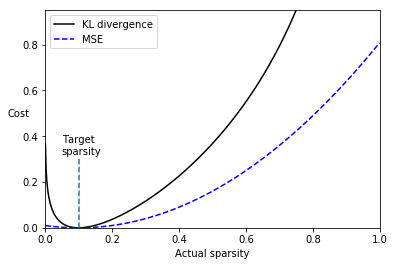

In [104]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot(q, kl_div, "k-", label="KL divergence")
plt.plot(q, mse, "b--", label="MSE")
plt.plot([p, p], [0, 0.3],'--')
plt.text(0.05, 0.32, "Target\nsparsity")
plt.axis([0, 1, 0, 0.95])
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=None)
plt.legend(loc="upper left")
plt.show() 

In [105]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [106]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

optimizer = tf.train.AdamOptimizer(learning_rate)

hidden1_mean = tf.reduce_mean(hidden1, axis=0)
sparsity_loss = tf.reduce_mean(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

training_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [107]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.08790302 	Sparsity loss: 0.32332996 	Total loss: 0.15256903
1 Train MSE: 0.076438524 	Sparsity loss: 0.3103739 	Total loss: 0.1385133
2 Train MSE: 0.075085826 	Sparsity loss: 0.31063423 	Total loss: 0.13721266
3 Train MSE: 0.06925725 	Sparsity loss: 0.27201584 	Total loss: 0.123660415
4 Train MSE: 0.06853521 	Sparsity loss: 0.23937412 	Total loss: 0.11641003
5 Train MSE: 0.065528795 	Sparsity loss: 0.18212551 	Total loss: 0.101953894
6 Train MSE: 0.058179926 	Sparsity loss: 0.11743277 	Total loss: 0.081666484
7 Train MSE: 0.04189835 	Sparsity loss: 0.054217212 	Total loss: 0.052741796
8 Train MSE: 0.028470198 	Sparsity loss: 0.02522578 	Total loss: 0.033515353
9 Train MSE: 0.021299407 	Sparsity loss: 0.01444171 	Total loss: 0.02418775
10 Train MSE: 0.01626067 	Sparsity loss: 0.008702186 	Total loss: 0.018001107
11 Train MSE: 0.013493756 	Sparsity loss: 0.008325302 	Total loss: 0.015158816
12 Train MSE: 0.011760417 	Sparsity loss: 0.008183146 	Total loss: 0.013397046
13 T

## Variational Autoencoders

In [115]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

my_dense_layer = partial(tf.layers.dense, 
                        activation=tf.nn.elu,
                        kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
X = tf.placeholder(tf.float32, [None, n_inputs])

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = tf.exp(0.5 * hidden3_gamma)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.nn.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))

eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [116]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 18651.793 	Reconstruction loss: 14914.895 	Latent loss: 3736.8977
19% Train total loss: 17636.285 	Reconstruction loss: 13800.318 	Latent loss: 3835.9666
2 Train total loss: 16275.697 	Reconstruction loss: 12523.297 	Latent loss: 3752.4004
3 Train total loss: 16528.715 	Reconstruction loss: 12710.905 	Latent loss: 3817.8103
4 Train total loss: 15686.456 	Reconstruction loss: 12021.627 	Latent loss: 3664.8293
5 Train total loss: 15730.357 	Reconstruction loss: 11892.512 	Latent loss: 3837.8452
6 Train total loss: 15801.73 	Reconstruction loss: 12008.39 	Latent loss: 3793.3408
7 Train total loss: 15399.066 	Reconstruction loss: 11532.357 	Latent loss: 3866.709
8 Train total loss: 15583.602 	Reconstruction loss: 11718.346 	Latent loss: 3865.2563
9 Train total loss: 15823.311 	Reconstruction loss: 12026.365 	Latent loss: 3796.9448
10 Train total loss: 15299.943 	Reconstruction loss: 11583.449 	Latent loss: 3716.4941
11 Train total loss: 15382.653 	Reconstruction loss: 1

### Generating Digits

In [117]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

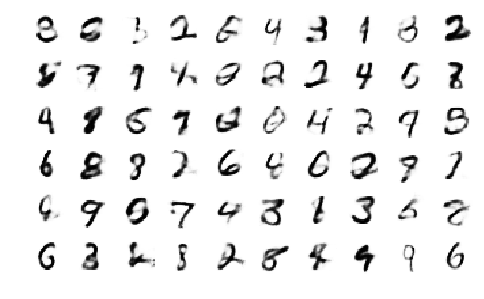

In [120]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])
plt.show()